# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import re
import numpy as np
import datetime
from datetime import datetime, timedelta
import time

In [2]:
df = pd.read_csv('main_task.csv')
df['Restaurant_id'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df['Restaurant_id']=pd.to_numeric(df['Restaurant_id'], )

In [3]:
df.drop(columns=['URL_TA'], axis=1, inplace=True)
df['Number of Reviews'].fillna(value=0, inplace=True)
df['Price Range'].fillna(value=0, inplace=True)
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,ID_TA
0,5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",d1912643
1,1535,Stockholm,NaN,1537.0,4.0,0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",d7992032
2,352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",d8632781
3,3456,Berlin,NaN,3458.0,5.0,0,3.0,"[[], []]",d1358776
4,615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",d6864963


In [4]:
df['Price Range'].value_counts()

$$ - $$$    18412
0           13886
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [5]:
price_dict={0:0, '$':1, '$$ - $$$':2, '$$$$':3}

In [6]:
df['Price Range'] = df['Price Range'].replace(to_replace=price_dict)
df['Price Range'].value_counts()

2    18412
0    13886
1     6279
3     1423
Name: Price Range, dtype: int64

In [7]:
cities=df['City'].value_counts()

In [8]:
cities_dummies=pd.get_dummies(df['City'], drop_first=True)

In [9]:
df = pd.concat([pd.DataFrame(df), cities_dummies], axis=1)

In [10]:
df.drop(columns='City', inplace=True)

In [11]:
df['Cuisine Style'] = df.apply(lambda x: x['Cuisine Style'].replace('[', '').replace(']', '').replace(
    "'", '').replace(' ', '') if type(x['Cuisine Style']) != float else x['Cuisine Style'], axis=1)

In [12]:
df['Cuisine Style'] = df['Cuisine Style'].fillna('Other')

In [13]:
df['cuisines_count'] = df['Cuisine Style'].str.split(',').str.len().fillna(1)
df['cuisines_count'].mean()

2.6224

In [14]:
cuisines = df['Cuisine Style'].str.get_dummies(
    ',').sum().sort_values(ascending=False)
top_cuisines = [x for x in cuisines.index if cuisines[x] < 1000]

In [15]:
df = df.join(df['Cuisine Style'].str.get_dummies(
    ',').drop(top_cuisines, axis=1), how='left')

In [16]:
df.drop(columns='Cuisine Style', inplace=True)

In [17]:
df['Reviews'] = df.apply(lambda x: x['Reviews'].replace('[[], []]', 'No reviews'), axis=1)

In [18]:
df['Reviews'] = df['Reviews'].apply(lambda x: x.replace(
    '[[', ''))
df['Reviews'] = df['Reviews'].apply(lambda x: x.replace(
    ']]', ''))
df['Reviews'] = df['Reviews'].apply(lambda x: x.replace(
    '[', ''))
df['Reviews'] = df['Reviews'].apply(lambda x: x.replace(
    ']', ''))
df['Reviews'] = df['Reviews'].apply(lambda x: str(x) if type(x) == list else x)
time_reviews = []
for item in df['Reviews']:
    time_reviews.append(re.findall(r'(\d\d/\d\d/\d\d\d\d)', item))
reviews = pd.DataFrame(time_reviews)
df['first_date_reviews'] = pd.to_datetime(reviews[0])
df['second_date_reviews']= pd.to_datetime(reviews[1])

In [19]:
df['first_date_reviews'].max()

Timestamp('2018-02-26 00:00:00')

In [20]:
df['second_date_reviews'].max()

Timestamp('2018-02-26 00:00:00')

In [21]:
df['difference_between_reviews_date'] = df['first_date_reviews']-df['second_date_reviews']
df['difference_between_reviews_date'].max()

Timedelta('3207 days 00:00:00')

In [22]:
df.drop(columns=['Reviews'], axis=1, inplace=True)

In [23]:
df['first_date_reviews'].fillna(value=0, inplace=True)
df['second_date_reviews'].fillna(value=0, inplace=True)
df['difference_between_reviews_date'].fillna(value=pd.Timedelta(seconds=0), inplace=True)

In [24]:
import numpy as np 
df['difference_between_reviews_date']=(df['difference_between_reviews_date'] / np.timedelta64(1, 'D')).astype(int) 

In [25]:
df.drop(columns=['first_date_reviews', 'second_date_reviews'], axis=1, inplace=True)

In [26]:
df['ID_TA']=df['ID_TA'].apply(lambda x: x.replace('d', ''))
df['ID_TA']=df['ID_TA'].astype(int)

In [27]:
import seaborn as sns

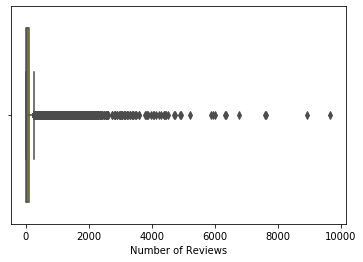

In [28]:
sns.boxplot(df['Number of Reviews'] , color='yellow');

In [29]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [30]:
o = outliers_iqr(df['Number of Reviews'].dropna())
df_selected = df[['Restaurant_id', 'Ranking', 'Rating', 'Price Range',
                 'Number of Reviews', 'ID_TA', 'difference_between_reviews_date']]

Мы видим, что в столбце['Number of Reviews'] довольно много выбросовб посмотрим еще более внимательно на этот столбец при построении матрицы корреляций.

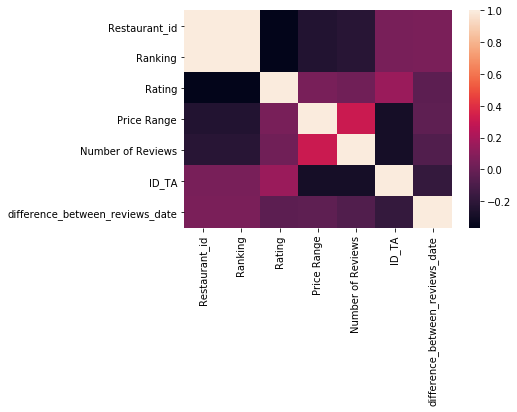

In [31]:
import seaborn as sns
corr = df_selected.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [32]:
import pandas as pd
import numpy as np
corr = df_selected.corr()
corr.style.background_gradient(cmap='coolwarm')


,Restaurant_id,Ranking,Rating,Price Range,Number of Reviews,ID_TA,difference_between_reviews_date
Restaurant_id,1.000000,1.000000,-0.368308,-0.243545,-0.222036,0.048820,0.056054
Ranking,1.000000,1.000000,-0.368371,-0.243553,-0.222072,0.048826,0.056043
Rating,-0.368308,-0.368371,1.000000,0.051643,0.026924,0.159111,-0.039930
Price Range,-0.243545,-0.243553,0.051643,1.000000,0.312668,-0.291264,-0.033257
Number of Reviews,-0.222036,-0.222072,0.026924,0.312668,1.000000,-0.289781,-0.079650
ID_TA,0.048820,0.048826,0.159111,-0.291264,-0.289781,1.000000,-0.176519
difference_between_reviews_date,0.056054,0.056043,-0.039930,-0.033257,-0.079650,-0.176519,1.000000


In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(df)

array([[0.33911826, 0.33868515, 0.625     , ..., 0.        , 0.        ,
        0.11291678],
       [0.09347217, 0.09341361, 0.75      , ..., 0.        , 0.        ,
        0.20846175],
       [0.02143466, 0.02140729, 0.875     , ..., 1.        , 1.        ,
        0.10198935],
       ...,
       [0.10041408, 0.10040747, 0.875     , ..., 0.        , 0.        ,
        0.97758476],
       [0.03897211, 0.03892234, 0.75      , ..., 0.        , 1.        ,
        0.10787335],
       [0.29375228, 0.29349875, 0.5       , ..., 0.        , 0.        ,
        0.4673578 ]])

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [34]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [35]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [36]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [37]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [38]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [39]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
#0.26930400000000004
#0.265753
#0.22159299999999998
#0.2214375

MAE: 0.2214375
